<a href="https://colab.research.google.com/github/manideep1428/Clone-Instagram/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from pathlib import Path
from PIL import Image
import random

In [5]:
!pip install torchinfo
from torchinfo import summary

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Model is using {device}')

Model is using cpu


##Download the DataCustom DataSet

In [7]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

#If data don't exist
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  with open (data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  #Unzip the file
  with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists


In [8]:

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / "train"
test_dir = image_path / "test"

## Define transforms

In [9]:
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

## Load datasets and

##Create DataLoaders

In [10]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

## Define model


In [11]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 16 * 16, output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [12]:
torch.manual_seed(42)
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)

# Display model summary
summary(model, input_size=(1, 3, 64, 64))


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

##Define training and testing functions


In [13]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    return train_loss / len(dataloader), train_acc / len(dataloader)


def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    return test_loss / len(dataloader), test_acc / len(dataloader)


##Define training loop

In [14]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

## Set up loss function and optimizer


In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Train the model


In [18]:

epochs = 15
results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs)


Epoch: 1 | train_loss: 1.0914 | train_acc: 0.4062 | test_loss: 1.0710 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.1137 | train_acc: 0.2812 | test_loss: 1.0620 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0962 | train_acc: 0.4023 | test_loss: 1.0811 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.1019 | train_acc: 0.2812 | test_loss: 1.0834 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.0967 | train_acc: 0.2812 | test_loss: 1.0933 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.0925 | train_acc: 0.4141 | test_loss: 1.1066 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.0888 | train_acc: 0.4141 | test_loss: 1.1279 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1132 | train_acc: 0.2930 | test_loss: 1.1289 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.0805 | train_acc: 0.2930 | test_loss: 1.0774 | test_acc: 0.3617
Epoch: 10 | train_loss: 1.0119 | train_acc: 0.5234 | test_loss: 1.0243 | test_acc: 0.5947
Epoch: 11 | train_loss: 0.9855 | train_acc: 0.4258 | test_loss: 1.0090 | test_acc: 0.5047
Epoch: 12 | train_l

## Plot results


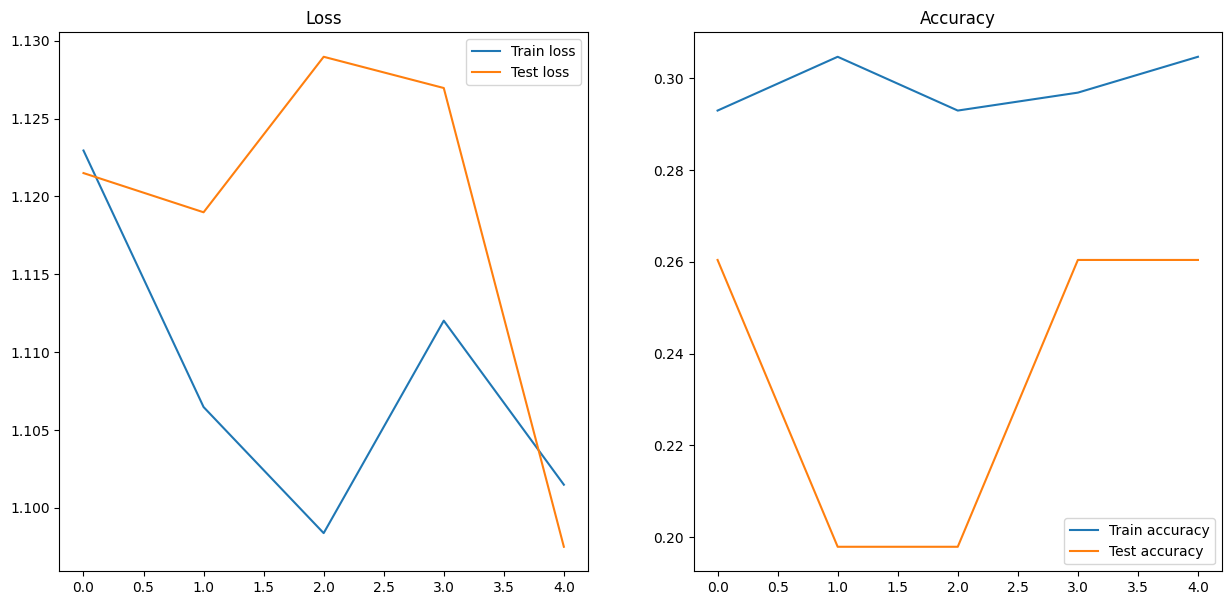

In [17]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Train loss')
plt.plot(results['test_loss'], label='Test loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['train_acc'], label='Train accuracy')
plt.plot(results['test_acc'], label='Test accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()